In [1]:
from sem_objnav.segment.infer import EmsanetWrapper

import glob
import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
def calculate_bin_stats(sem_gt, sem_pred, confidence, NUM_BINS):
    bin_accuracies, bin_confidences, bin_counts = (
        np.zeros(NUM_BINS),
        np.zeros(NUM_BINS),
        np.zeros(NUM_BINS),
    )
    valid_mask = (sem_pred > 2)
    for j in range(NUM_BINS):
        p1, p2 = j / NUM_BINS, (j + 1) / NUM_BINS
        confidence_bin_mask = (confidence > p1) & (confidence <= p2) & valid_mask

        bin_count = confidence_bin_mask.sum()
        if bin_count > 0:
            points_, labels_ = (
                sem_pred[confidence_bin_mask],
                sem_gt[confidence_bin_mask],
            )
            bin_accuracy = (points_ == labels_).sum()
            bin_confidence = confidence[confidence_bin_mask].sum()

            bin_accuracies[j] = bin_accuracy
            bin_confidences[j] = bin_confidence
            bin_counts[j] = bin_count
    return bin_accuracies, bin_confidences, bin_counts


import random
import torch

def compute(model, temp=1.0, split="train", num_items=None):
    image_dir = (
    f"/home/sai/Desktop/multi-object-search/third_party/EMSANet/datasets/hm3d_objnav_8_classes/{split}/rgb"
    )
    depth_dir = f"/home/sai/Desktop/multi-object-search/third_party/EMSANet/datasets/hm3d_objnav_8_classes/{split}/depth"
    semantic_seg_gt = f"/home/sai/Desktop/multi-object-search/third_party/EMSANet/datasets/hm3d_objnav_8_classes/{split}/semantic_8"
    rgb_images = sorted(glob.glob(image_dir + "/*.png"))
    depth_images = sorted(glob.glob(depth_dir + "/*.png"))
    seg_gt_images = sorted(glob.glob(semantic_seg_gt + "/*.png"))
    if num_items is not None:
        rgb_images = random.Random(42).sample(rgb_images, num_items)
        seg_gt_images = random.Random(42).sample(seg_gt_images, num_items)
        depth_images = random.Random(42).sample(depth_images, num_items)
        
    #miou = MeanIntersectionOverUnion(n_classes=7, ignore_first_class=True)

    NUM_BINS = 10
    bin_accuracies, bin_confidences, bin_counts = (
        np.zeros(NUM_BINS),
        np.zeros(NUM_BINS),
        np.zeros(NUM_BINS),
    )
    ubin_accuracies, ubin_confidences, ubin_counts = (
        np.zeros(NUM_BINS),
        np.zeros(NUM_BINS),
        np.zeros(NUM_BINS),
    )
    model.temp = temp
    for i in tqdm.tqdm(
        range(len(rgb_images))
    ):
        image = rgb_images[i]
        depth = depth_images[i]
        semantic_gt = seg_gt_images[i]
        # Get the semantic segmentation ground truth for the image
        semantic_gt_img = Image.open(semantic_gt)
        semantic_gt = torch.from_numpy(np.array(semantic_gt_img))
        semantic_gt -= 2
        semantic_gt[semantic_gt > 200] = 0
        image = np.array(Image.open(image))
        depth_image = np.array(Image.open(depth))
        out = model.predict(image, depth_image)
        normalized_entropy = out["semantic_unc"]
        conf = (1 - normalized_entropy)
        segmentation_pred = out["semantic"] - 2
        segmentation_max_prob = out["semantic_max_prob"]
  
        b_acc, b_conf, b_cnt = calculate_bin_stats(semantic_gt.cpu().numpy(), segmentation_pred, segmentation_max_prob, NUM_BINS)
        ub_acc, ub_conf, ub_cnt = calculate_bin_stats(semantic_gt.cpu().numpy(), segmentation_pred, conf, NUM_BINS)
        bin_accuracies += np.array(b_acc)
        bin_confidences += np.array(b_conf)
        bin_counts += np.array(b_cnt)
        
        ubin_accuracies += np.array(ub_acc)
        ubin_confidences += np.array(ub_conf)
        ubin_counts += np.array(ub_cnt)
    bin_confidences_avg = np.divide(
            bin_confidences,
            bin_counts,
            out=np.zeros_like(bin_confidences),
            where=bin_counts != 0,
    )
    bin_accuracies_avg = np.divide(
        bin_accuracies,
        bin_counts,
        out=np.zeros_like(bin_accuracies),
        where=bin_counts != 0,
    )
    overall_ece = (
        np.sum(
            bin_counts * np.abs(bin_accuracies_avg - bin_confidences_avg),
        )
        / bin_counts.sum()
    )
    ubin_confidences_avg = np.divide(
            ubin_confidences,
            ubin_counts,
            out=np.zeros_like(ubin_confidences),
            where=ubin_counts != 0,
    )
    ubin_accuracies_avg = np.divide(
        ubin_accuracies,
        ubin_counts,
        out=np.zeros_like(ubin_accuracies),
        where=ubin_counts != 0,
    )
    overal_uece = (
        np.sum(
            ubin_counts * np.abs(ubin_accuracies_avg - ubin_confidences_avg),
        )
        / ubin_counts.sum()
    )
    
    return bin_confidences_avg, bin_accuracies_avg, overall_ece, ubin_confidences_avg, ubin_accuracies_avg, overal_uece

def plot(bin_confidences, bin_accuracies, title, save_path=None):
    plt.title(title)
    plt.plot([0, 1], [0, 1], color="black", linewidth=2)
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.plot(bin_confidences, bin_accuracies, color="b")
    plt.legend(["Perfect calibration", "Model"])
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

/home/sai/miniconda3/envs/hobjn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pybullet build time: May  2 2023 05:58:25


In [2]:
emsanetmodel = EmsanetWrapper(ckpt_path='/home/sai/Desktop/multi-object-search/third_party/trained_models/sunrgbd/r34_NBt1D_pre.pth', config_path='/home/sai/Desktop/multi-object-search/third_party/trained_models/sunrgbd/argsv.txt', map_schema="objnav_occ_id")
e_bin_confidences_avg, e_bin_accuracies_avg, e_overall_ece, e_ubin_confidences_avg, e_ubin_accuracies_avg, e_overal_uece  = compute(emsanetmodel, temp=3.2, split="val")
print("overall ece", e_overall_ece)
print("overall uece", e_overal_uece)
# plot(e_bin_confidences_avg, e_bin_accuracies_avg, "ECE")
# plot(e_ubin_confidences_avg, e_ubin_accuracies_avg, "uECE")


In [3]:
e_bin_confidences_avg_0, e_bin_accuracies_avg_0, e_overall_ece_0, e_ubin_confidences_avg_0, e_ubin_accuracies_avg_0, e_overal_uece_0  = compute(emsanetmodel, temp=1.0, split="val")
print("overall ece", e_overall_ece_0)
print("overall uece", e_overal_uece_0)
# plot(e_bin_confidences_avg, e_bin_accuracies_avg, "ECE")
# plot(e_ubin_confidences_avg, e_ubin_accuracies_avg, "uECE")


In [4]:
from sem_objnav.segment.infer import SegformerWrapper
segformer_model = SegformerWrapper(map_schema="objnav_occ_id")
s_bin_confidences_avg, s_bin_accuracies_avg, s_overall_ece, s_ubin_confidences_avg, s_ubin_accuracies_avg, s_overal_uece  = compute(segformer_model, temp=2.5, split="val")
print("overall ece", s_overall_ece)
print("overall uece", s_overal_uece)
# plot(s_bin_confidences_avg, s_bin_accuracies_avg, "ECE")
# plot(s_ubin_confidences_avg, s_ubin_accuracies_avg, "uECE")

In [5]:
s_bin_confidences_avg_0, s_bin_accuracies_avg_0, s_overall_ece_0, s_ubin_confidences_avg_0, s_ubin_accuracies_avg_0, s_overal_uece_0  = compute(segformer_model, temp=1.0, split="val")
print("overall ece", s_overall_ece_0)
print("overall uece", s_overal_uece_0)
# plot(s_bin_confidences_avg, s_bin_ac

In [48]:
def plot(conf_acc_color_labels, title, save_path=None):
    plt.title(title)
    #set font sizes
    plt.plot([0, 1], [0, 1], color="black", linewidth=2, linestyle='-', label="Perfect calibration")
    plt.xlabel("Confidence", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)
    for conf, acc, color, linestyle, label in conf_acc_color_labels:
        plt.plot(conf, acc, color=color, label=label, linestyle=linestyle)
    leg = plt.legend(loc=0, prop={'size': 12})
    # change the line width for the legend
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
    


In [49]:
# import pickle
# with open("calibration_data.pkl", "wb") as f:
#     x = [
#     (e_bin_confidences_avg, e_bin_accuracies_avg, e_overall_ece, e_ubin_confidences_avg, e_ubin_accuracies_avg, e_overal_uece),
#     (e_bin_confidences_avg_0, e_bin_accuracies_avg_0, e_overall_ece_0, e_ubin_confidences_avg_0, e_ubin_accuracies_avg_0, e_overal_uece_0),
#     (s_bin_confidences_avg, s_bin_accuracies_avg, s_overall_ece, s_ubin_confidences_avg, s_ubin_accuracies_avg, s_overal_uece),
#     (s_bin_confidences_avg_0, s_bin_accuracies_avg_0, s_overall_ece_0, s_ubin_confidences_avg_0, s_ubin_accuracies_avg_0, s_overal_uece_0),]
#     pickle.dump(x, f)
# with open("calibration_data.pkl", "rb") as f:
#     x = pickle.load(f)
#     e_bin_confidences_avg, e_bin_accuracies_avg, e_overall_ece, e_ubin_confidences_avg, e_ubin_accuracies_avg, e_overal_uece = x[0]
#     e_bin_confidences_avg_0, e_bin_accuracies_avg_0, e_overall_ece_0, e_ubin_confidences_avg_0, e_ubin_accuracies_avg_0, e_overal_uece_0 = x[1]
#     s_bin_confidences_avg, s_bin_accuracies_avg, s_overall_ece, s_ubin_confidences_avg, s_ubin_accuracies_avg, s_overal_uece = x[2]
#     s_bin_confidences_avg_0, s_bin_accuracies_avg_0, s_overall_ece_0, s_ubin_confidences_avg_0, s_ubin_accuracies_avg_0, s_overal_uece_0 = x[3]

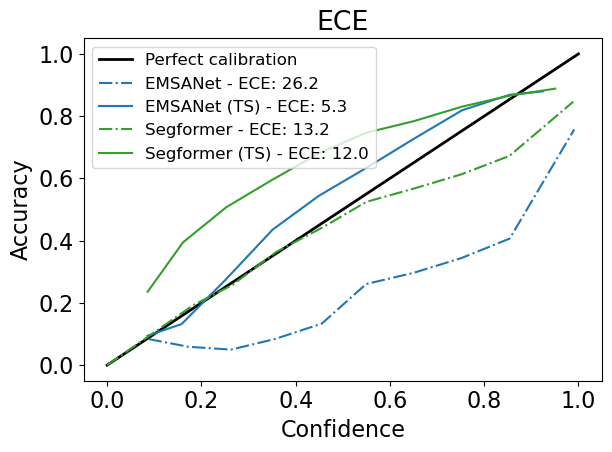

In [54]:
plot([
    (e_bin_confidences_avg_0, e_bin_accuracies_avg_0, plt.colormaps['Paired'].colors[1], "-.", f"EMSANet - ECE: {e_overall_ece_0 * 100:.1f}"), 
    (e_bin_confidences_avg, e_bin_accuracies_avg, plt.colormaps['Paired'].colors[1], "solid", f"EMSANet (TS) - ECE: {e_overall_ece * 100:.1f}"), 
    (s_bin_confidences_avg_0, s_bin_accuracies_avg_0, plt.colormaps['Paired'].colors[3], "-.", f"Segformer - ECE: {s_overall_ece_0 * 100:.1f}"), 
    (s_bin_confidences_avg, s_bin_accuracies_avg, plt.colormaps['Paired'].colors[3], "solid", f"Segformer (TS) - ECE: {s_overall_ece * 100:.1f}")], 
     title="ECE", save_path="ece.pdf")

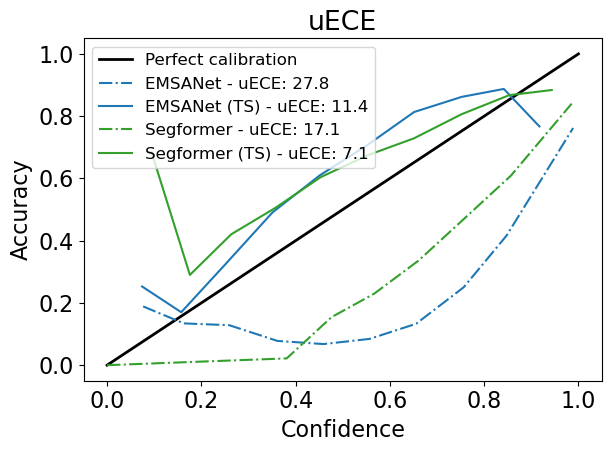

In [55]:
plot([
    (e_ubin_confidences_avg_0, e_ubin_accuracies_avg_0, plt.colormaps['Paired'].colors[1], "-.", f"EMSANet - uECE: {e_overal_uece_0 * 100:.1f}"), 
    (e_ubin_confidences_avg, e_ubin_accuracies_avg, plt.colormaps['Paired'].colors[1], "solid", f"EMSANet (TS) - uECE: {e_overal_uece * 100:.1f}"), 
    (s_ubin_confidences_avg_0, s_ubin_accuracies_avg_0, plt.colormaps['Paired'].colors[3], "-.", f"Segformer - uECE: {s_overal_uece_0 * 100:.1f}"), 
    (s_ubin_confidences_avg, s_ubin_accuracies_avg, plt.colormaps['Paired'].colors[3], "solid", f"Segformer (TS) - uECE: {s_overal_uece * 100:.1f}")], 
     "uECE", save_path="uece.pdf")